### **Implementing a Question Answer System using Neural Networks**



1.   Chris Mary Benson(2020A7PS0027U)
2.   Vanshika Sangtani(2020A7PS0031U)



## **Importing Packages**

In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

import numpy as np
import re

import pandas as pd

## **Importing** **SQuAD** **dataset**

In [ ]:
!pip install datasets
from datasets import load_dataset

# Load the SQuAD dataset
squad_dataset = load_dataset("squad")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.1 MB/s eta 0:00:00


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

In [ ]:
qa_data = squad_dataset["train"]

valid_data = squad_dataset["validation"]

In [ ]:
qa_data

Dataset({
    features: ['id', 'title', 'context', 'question', 'answers'],
    num_rows: 87599
})

In [ ]:
qa_data["context"]

In [ ]:
qa_data['answers']

[{'text': ['Saint Bernadette Soubirous'], 'answer_start': [515]},
 {'text': ['a copper statue of Christ'], 'answer_start': [188]},
 {'text': ['the Main Building'], 'answer_start': [279]},
 {'text': ['a Marian place of prayer and reflection'], 'answer_start': [381]},
 {'text': ['a golden statue of the Virgin Mary'], 'answer_start': [92]},
 {'text': ['September 1876'], 'answer_start': [248]},
 {'text': ['twice'], 'answer_start': [441]},
 {'text': ['The Observer'], 'answer_start': [598]},
 {'text': ['three'], 'answer_start': [126]},
 {'text': ['1987'], 'answer_start': [908]},
 {'text': ['Rome'], 'answer_start': [119]},
 {'text': ['Moreau Seminary'], 'answer_start': [145]},
 {'text': ['Old College'], 'answer_start': [234]},
 {'text': ['Retired priests and brothers'], 'answer_start': [356]},
 {'text': ['Buechner Prize for Preaching'], 'answer_start': [675]},
 {'text': ['eight'], 'answer_start': [487]},
 {'text': ['1920'], 'answer_start': [46]},
 {'text': ['the College of Science'], 'answer_

## **Pre**-**processing** **the** **data**

In [ ]:
lookup = 'abcdefghijklmnopqrstuvwxyz1234567890?.,'
# to check for valid characters in the data to convert to lowercase
def in_white_list(_word):
    valid_word = False
    for char in _word:
        if char in lookup:
            valid_word = True
            break

    if valid_word is False:
        return False

    return True

In [ ]:
def count_words(string):
    words = string.split()
    return len(words)

In [ ]:
def pre_process_data(qa_data,max_data_count,max_context_seq_length,max_question_seq_length,max_target_seq_length):
  data = list()
  for instance in qa_data:
      context = instance['context']
      context_wid_list = [w.lower() for w in nltk.word_tokenize(context) if in_white_list(w)]
      print(context_wid_list)
      new_context = " ".join(context_wid_list)
      if len(context_wid_list) > max_context_seq_length:
                continue
      question = instance['question']
      print(question)
      question_wid_list = [w.lower() for w in nltk.word_tokenize(question) if in_white_list(w)]
      new_question = " ".join(question_wid_list)
      if len(question_wid_list) > max_question_seq_length:
                    continue
      answers = instance['answers']
      #print(answers['text'])
      answ = answers['text']
      word_count = count_words(answ[0])
      #print("Number of words:", word_count)
      if word_count == 1:
        for ans in answ:
          answer_wid_list = [w.lower() for w in nltk.word_tokenize(ans) if in_white_list(w)]
          new_answer = " ".join(answer_wid_list)
          print(new_answer)
          if len(answer_wid_list) > max_target_seq_length:
                  continue
        if len(data) < max_data_count:
                data.append((new_context, new_question, new_answer))
  return data

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
#preprocessing the training data
max_data_count = 8000
max_context_seq_length = 300
max_question_seq_length = 60
max_target_seq_length = 50

data = pre_process_data(qa_data, max_data_count, max_context_seq_length, max_question_seq_length, max_target_seq_length)

print("Total Q&A data size", len(data))

In [ ]:
len(data)

8000

In [ ]:
data[400]

('tracks of the northern pacific railroad reached montana from the west in 1881 and from the east in 1882 . however , the railroad played a major role in sparking tensions with native american tribes in the 1870s . jay cooke , the president launched major surveys into the yellowstone valley in 1871 , 1872 and 1873 which were challenged forcefully by the sioux under chief sitting bull . these clashes , in part , contributed to the panic of 1873 which delayed construction of the railroad into montana . surveys in 1874 , 1875 and 1876 helped spark the great sioux war of 1876 . the transcontinental was completed on september 8 , 1883 , at gold creek .',
 'when was the transcontinental national pacific railroad finished ?',
 '1883')

In [ ]:
#train-test split
import random
from sklearn.model_selection import train_test_split

random.seed(42)
s_data = random.sample(data, len(data))

squad_data_train, squad_data_test = train_test_split(s_data, test_size = 0.2, random_state = 42)

In [ ]:
len(squad_data_train), len(squad_data_test)

(6400, 1600)

In [ ]:
squad_data = []
for context, query, answer in squad_data_train:
  context_list = [w for w in nltk.word_tokenize(context)]
  question_list = [w for w in nltk.word_tokenize(query)]
  squad_data.append((context_list, question_list, answer))

In [ ]:
squad_test_data = []
for context, query, answer in squad_data_test:
  context_list = [w for w in nltk.word_tokenize(context)]
  question_list = [w for w in nltk.word_tokenize(query)]
  squad_test_data.append((context_list, question_list, answer))

In [ ]:
squad_data[200]

(['plymouth',
  'lies',
  'between',
  'the',
  'river',
  'plym',
  'to',
  'the',
  'east',
  'and',
  'the',
  'river',
  'tamar',
  'to',
  'the',
  'west',
  'both',
  'rivers',
  'flow',
  'into',
  'the',
  'natural',
  'harbour',
  'of',
  'plymouth',
  'sound',
  '.',
  'since',
  '1967',
  ',',
  'the',
  'unitary',
  'authority',
  'of',
  'plymouth',
  'has',
  'included',
  'the',
  ',',
  'once',
  'independent',
  ',',
  'towns',
  'of',
  'plympton',
  'and',
  'plymstock',
  'which',
  'lie',
  'along',
  'the',
  'east',
  'of',
  'the',
  'river',
  'plym',
  '.',
  'the',
  'river',
  'tamar',
  'forms',
  'the',
  'county',
  'boundary',
  'between',
  'devon',
  'and',
  'cornwall',
  'and',
  'its',
  'estuary',
  'forms',
  'the',
  'hamoaze',
  'on',
  'which',
  'is',
  'sited',
  'devonport',
  'dockyard',
  '.'],
 ['the',
  'river',
  'tamar',
  'is',
  'the',
  'boundary',
  'between',
  'devon',
  'and',
  'what',
  'other',
  'county',
  '?'],
 'cornwall'

In [ ]:
squad_test_data[200]

(['on',
  'release',
  ',',
  'twilight',
  'princess',
  'was',
  'considered',
  'to',
  'be',
  'the',
  'greatest',
  'zelda',
  'game',
  'ever',
  'made',
  'by',
  'many',
  'critics',
  'including',
  'writers',
  'for',
  '1up.com',
  ',',
  'computer',
  'and',
  'video',
  'games',
  ',',
  'electronic',
  'gaming',
  'monthly',
  ',',
  'game',
  'informer',
  ',',
  'gamesradar',
  ',',
  'and',
  'the',
  'washington',
  'post',
  '.',
  'game',
  'informer',
  'called',
  'it',
  'so',
  'creative',
  'that',
  'it',
  'rivals',
  'the',
  'best',
  'that',
  'hollywood',
  'has',
  'to',
  'offer',
  '.',
  'gamesradar',
  'praised',
  'twilight',
  'princess',
  'as',
  'a',
  'game',
  'that',
  'deserves',
  'nothing',
  'but',
  'the',
  'absolute',
  'highest',
  'recommendation',
  '.',
  'cubed3',
  'hailed',
  'twilight',
  'princess',
  'as',
  'the',
  'single',
  'greatest',
  'videogame',
  'experience',
  '.',
  'twilight',
  'princess',
  "'s",
  'graphics

## **Vectorizing the context, query, answer**

In [ ]:
def vectorize(data, word_idx, story_maxlen, query_maxlen):
    X = []
    Xq = []
    Y = []
    for context, query, answer in data:
        x = [word_idx[w] for w in context]
        xq = [word_idx[w] for w in query]
        y = np.zeros(len(word_idx) + 1)
        y[word_idx[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return (pad_sequences(X, maxlen=context_maxlen),
            pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))

## **Creating a Vocabulary**

In [ ]:
vocab = set()
for context, q, answer in squad_data + squad_test_data:
    vocab |= set(context + q + [answer])
    print([answer])
vocab = sorted(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
context_maxlen = max(map(len, (x for x, _, _ in squad_data + squad_test_data)))
query_maxlen = max(map(len, (x for _, x, _ in squad_data + squad_test_data)))

In [ ]:
len(vocab)

30996

In [ ]:
context_maxlen, query_maxlen

(298, 33)

In [ ]:
print('Vocab size:', vocab_size, 'unique words')
print('Context max length:', context_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(squad_data))
print('Number of test stories:', len(squad_test_data))
print('-')
print('(Context, query, answer):')
print(squad_data_train[0])
print('-')
print('Vectorizing the word sequences...')

word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
idx_word = dict((i+1, c) for i,c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize(squad_data,
                                                               word_idx,
                                                               context_maxlen,
                                                               query_maxlen)
inputs_test, queries_test, answers_test = vectorize(squad_test_data,
                                                            word_idx,
                                                            context_maxlen,
                                                            query_maxlen)

Vocab size: 30997 unique words
Context max length: 298 words
Query max length: 33 words
Number of training stories: 6400
Number of test stories: 1600
-
(Context, query, answer):
("in 1919 nancy astor was elected the first ever female member of parliament to take office in the british houses of parliament for the constituency of plymouth sutton . taking over office from her husband waldorf astor , lady astor was a vibrantly active campaigner for her resident constituents . plymouth was granted city status on 18 october 1928 . the city 's first lord mayor was appointed in 1935 and its boundaries further expanded in 1967 to include the town of plympton and the parish of plymstock .", 'what parish was incorporated into plymouth in 1967 ?', 'plymstock')
-
Vectorizing the word sequences...


In [ ]:
inputs_train.shape, queries_train.shape, answers_train.shape

((6400, 298), (6400, 33), (6400, 30997))

In [ ]:
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)

inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (6400, 298)
inputs_test shape: (1600, 298)
-
queries: integer tensor of shape (samples, max_length)
queries_train shape: (6400, 33)
queries_test shape: (1600, 33)
-
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (6400, 30997)
answers_test shape: (1600, 30997)


In [ ]:
train_epochs = 200
batch_size = 32
lstm_size = 64

## **Bidirectional LSTM Model**

In [ ]:
from keras.layers import Bidirectional

In [ ]:
input_sequence = Input((context_maxlen,))
question = Input((query_maxlen,))

print('Input sequence:', input_sequence)
print('Question:', question)

input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
input_encoder_m.add(Dropout(0.3))

input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(0.3))

question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=query_maxlen))
question_encoder.add(Dropout(0.3))

input_encoded_m = input_encoder_m(input_sequence)
print('Input encoded m', input_encoded_m)
input_encoded_c = input_encoder_c(input_sequence)
print('Input encoded c', input_encoded_c)
question_encoded = question_encoder(question)
print('Question encoded', question_encoded)

match = dot([input_encoded_m, question_encoded], axes=(2, 2))
print(match.shape)
match = Activation('softmax')(match)
print('Match shape', match)

response = add([match, input_encoded_c])
response = Permute((2, 1))(response)
print('Response shape', response)

answer = concatenate([response, question_encoded])
print('Answer shape', answer)

answer = Bidirectional(LSTM(lstm_size, return_sequences=True))(answer)
answer = Dropout(0.5)(answer)
answer = Bidirectional(LSTM(lstm_size))(answer)
answer = Dropout(0.5)(answer)
answer = Dense(vocab_size)(answer)
answer = Activation('softmax')(answer)

Input sequence: KerasTensor(type_spec=TensorSpec(shape=(None, 298), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 33), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 298, 64), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 298, 33), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 33, 64), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'")
(None, 298, 33)
Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 298, 33), dtype=tf.float32, name=None), name

In [ ]:
model = Model([input_sequence, question], answer)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 298)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 33)]                 0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, 64)             1983808   ['input_1[0][0]']             
                                                                                                  
 sequential_2 (Sequential)   (None, 33, 64)               1983808   ['input_2[0][0]']             
                                                                                              

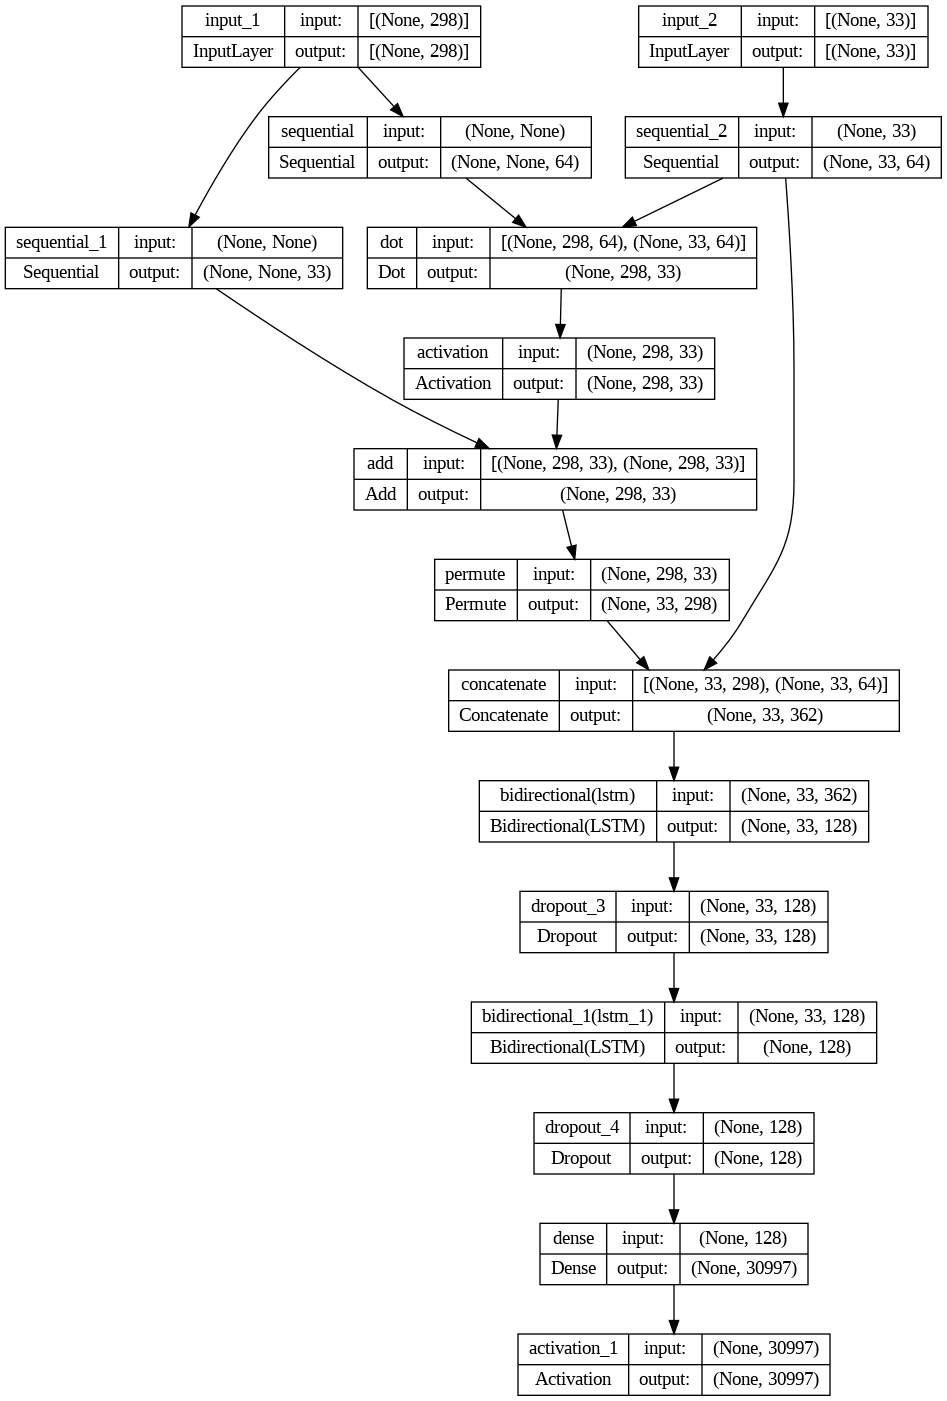

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.fit([inputs_train, queries_train], answers_train, batch_size, train_epochs, validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/200
200/200 [==============================] - 85s 366ms/step - loss: 9.4835 - accuracy: 0.0234 - val_loss: 9.1752 - val_accuracy: 0.0231
Epoch 2/200
200/200 [==============================] - 41s 205ms/step - loss: 8.4546 - accuracy: 0.0248 - val_loss: 9.1509 - val_accuracy: 0.0231
Epoch 3/200
200/200 [==============================] - 31s 153ms/step - loss: 8.1182 - accuracy: 0.0248 - val_loss: 9.0841 - val_accuracy: 0.0231
Epoch 4/200
200/200 [==============================] - 22s 110ms/step - loss: 7.8398 - accuracy: 0.0248 - val_loss: 9.1485 - val_accuracy: 0.0231
Epoch 5/200
200/200 [==============================] - 21s 103ms/step - loss: 7.6225 - accuracy: 0.0248 - val_loss: 9.3597 - val_accuracy: 0.0231
Epoch 6/200
200/200 [==============================] - 17s 86ms/step - loss: 7.4444 - accuracy: 0.0270 - val_loss: 9.4648 - val_accuracy: 0.0288
Epoch 7/200
200/200 [==============================] - 16s 82ms/step - loss: 7.2967 - accuracy: 0.0298 - val_loss: 9.6447 - v

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model.save('/content/drive/MyDrive/BILSTM_QnA_model'+'/qna_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model
new_model = load_model('/content/drive/MyDrive/BILSTM_QnA_model/qna_model.h5')

## **Evaluation Metrics**

In [ ]:
from collections import Counter

In [ ]:
def normalize_answer(answer):
    return answer.lower().strip()

def exact_match_score(prediction, ground_truth):
    return int(normalize_answer(prediction) == normalize_answer(ground_truth))

def f1_score(prediction, ground_truth):
    if len(prediction) == 0:
      p = -1
      r = -1
      f1 = -1
      print(" ")
    else:
      if not ground_truth:
          p = -1
          r = -1
          f1 = -1
          return 0, 0, 0

      common = Counter(normalize_answer(prediction)) & Counter(normalize_answer(ground_truth))
      num_common = sum(common.values())

      p = num_common / len(normalize_answer(prediction))
      print("Precision: ", p)
      r = num_common / len(normalize_answer(ground_truth))
      print("Recall: ", r)

      if p + r == 0:
          return 0, 0, 0

      f1 = (2 * p * r) / (p + r)
    return p, r, f1

## **Testing the model**

In [ ]:
precision_list = []
recall_list = []
f1_list = []
EM_scores = []
j = 0

In [ ]:
for i in range(0, 200):
        if j>0:
          current_inp = squad_data[i]
          j += 1
        else:
          current_inp = squad_test_data[i]
          j -= 1
        #current_inp = squad_test_data[i]
        current_context, current_query, current_answer = vectorize([current_inp], word_idx, context_maxlen, query_maxlen)
        current_prediction = model.predict([current_context, current_query])
        current_prediction = idx_word[np.argmax(current_prediction)]
        #print(current_inp[0])
        print("Context: ", ' '.join(current_inp[0]))
        print("Question: ", ' '.join(current_inp[1]))
        print('Prediction:', current_prediction, '| Actual:', current_inp[2])
        em = exact_match_score(current_prediction, current_inp[2])
        EM_scores.append(em)
        print("Exact Match (EM) score: ", em)
        p, r, f1 = f1_score(current_prediction, current_inp[2])
        if p == -1:
          print("Model could not predict an answer")
        else:
          print("f1 score: ", f1)
          f1_list.append(f1)
          precision_list.append(p)
          recall_list.append(r)
        print("-----------------------------------------------------------------------------------------")


1/1 [==============================] - 0s 24ms/step
Context:  beyoncé has worked with tommy hilfiger for the fragrances true star singing a cover version of wishing on a star and true star gold she also promoted emporio armani 's diamonds fragrance in 2007 . beyoncé launched her first official fragrance , heat in 2010 . the commercial , which featured the 1956 song fever , was shown after the water shed in the united kingdom as it begins with an image of beyoncé appearing to lie naked in a room . in february 2011 , beyoncé launched her second fragrance , heat rush . beyoncé 's third fragrance , pulse , was launched in september 2011 . in 2013 , the mrs. carter show limited edition version of heat was released . the six editions of heat are the world 's best-selling celebrity fragrance line , with sales of over 400 million .
Question:  beyonce 's first fragrance had what name ?
Prediction: pulse | Actual: heat
Exact Match (EM) score:  0
Precision:  0.2
Recall:  0.25
f1 score:  0.2222222

In [ ]:
for i in range(0, 100):
        current_inp = squad_data[i]
        #current_inp = squad_test_data[i]
        current_context, current_query, current_answer = vectorize([current_inp], word_idx, context_maxlen, query_maxlen)
        current_prediction = model.predict([current_context, current_query])
        current_prediction = idx_word[np.argmax(current_prediction)]
        #print(current_inp[0])
        print("Context: ", ' '.join(current_inp[0]))
        print("Question: ", ' '.join(current_inp[1]))
        print('Prediction:', current_prediction, '| Actual:', current_inp[2])
        em = exact_match_score(current_prediction, current_inp[2])
        #EM_scores.append(em)
        print("Exact Match (EM) score: ", em)
        p, r, f1 = f1_score(current_prediction, current_inp[2])
        if p == -1:
          print("Model could not predict an answer")
        else:
          print("f1 score: ", f1)
          #f1_list.append(f1)
          #precision_list.append(p)
          #recall_list.append(r)
        print("-----------------------------------------------------------------------------------------")


1/1 [==============================] - 0s 23ms/step
Context:  in 1919 nancy astor was elected the first ever female member of parliament to take office in the british houses of parliament for the constituency of plymouth sutton . taking over office from her husband waldorf astor , lady astor was a vibrantly active campaigner for her resident constituents . plymouth was granted city status on 18 october 1928 . the city 's first lord mayor was appointed in 1935 and its boundaries further expanded in 1967 to include the town of plympton and the parish of plymstock .
Question:  what parish was incorporated into plymouth in 1967 ?
Prediction: plymstock | Actual: plymstock
Exact Match (EM) score:  1
Precision:  1.0
Recall:  1.0
f1 score:  1.0
-----------------------------------------------------------------------------------------
1/1 [==============================] - 0s 26ms/step
Context:  bell began a series of public demonstrations and lectures to introduce the new invention to the scien

In [ ]:
p_avg = 0
r_avg = 0
f1_avg = 0
EM_avg = 0
for i in range(0, len(precision_list)):
  f1_avg += f1_list[i]
  p_avg += precision_list[i]
  r_avg += recall_list[i]
for i in range(0, len(EM_scores)):
  EM_avg += EM_scores[i]
print("F1 score: ", f1_avg/len(f1_list))
print("Precision: ", p_avg/len(precision_list))
print("Recall :", r_avg/len(recall_list))
print("EM score: ", EM_avg/len(EM_scores))

F1 score:  0.33456854802752023
Precision:  0.35123441056660243
Recall : 0.3394351827976559
EM score:  0.07


In [ ]:
precision_list

## **Plotting the graphs for the evaluation metrics**

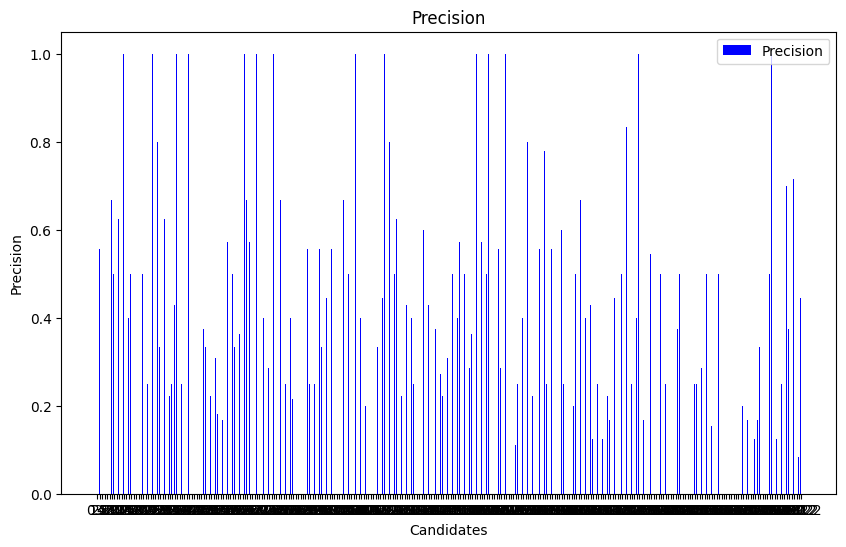

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(precision_list))

bar1 = ax.bar(index, precision_list, width=bar_width, label='Precision', color='blue')

ax.set_xlabel('Candidates')
ax.set_ylabel('Precision')
ax.set_title('Precision')
ax.set_xticks(index + bar_width)
ax.legend()

plt.show()

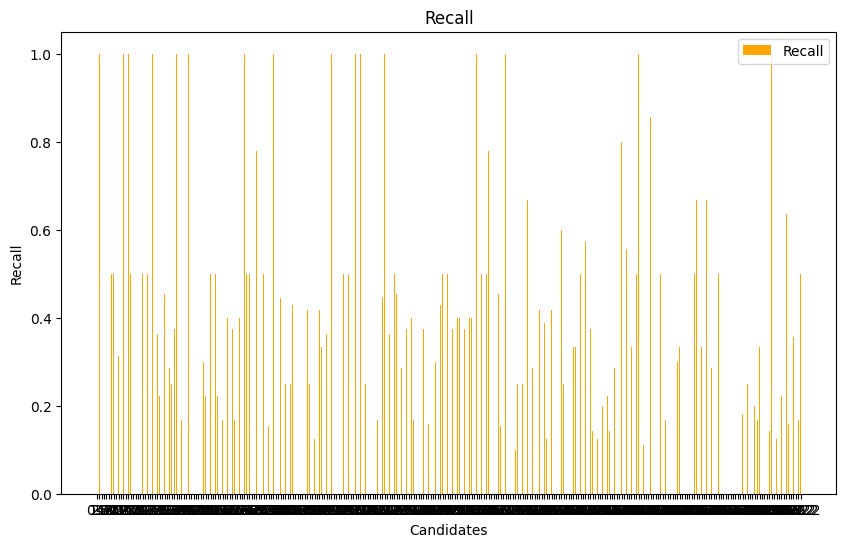

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(recall_list))

bar2 = ax.bar(index + bar_width, recall_list, width=bar_width, label='Recall', color='orange')

ax.set_xlabel('Candidates')
ax.set_ylabel('Recall')
ax.set_title('Recall')
ax.set_xticks(index + bar_width)
ax.legend()

plt.show()

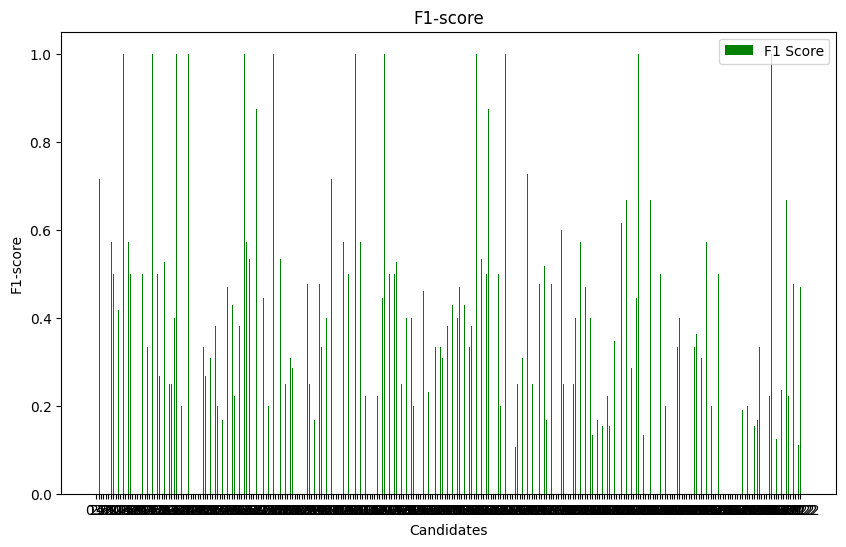

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.25
index = np.arange(len(f1_list))

bar3 = ax.bar(index + 2 * bar_width, f1_list, width=bar_width, label='F1 Score', color='green')

ax.set_xlabel('Candidates')
ax.set_ylabel('F1-score')
ax.set_title('F1-score')
ax.set_xticks(index + bar_width)
ax.legend()

plt.show()